In [1]:
path_prefix = '/home/backend/'
%matplotlib inline
import sys
sys.path.insert(1, path_prefix)
import pickle
from sklearn.neighbors import NearestNeighbors
from imagenet_similarity import similarity_resnet50, predict_resnet50, similarity_nasnet_large
import pixellib
from pixellib.instance import instance_segmentation
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import os

In [2]:
class Dataset:
    
    ALLOWED_IMG_EXTENSIONS = {'png', 'jpg', 'jpeg', 'gif', 'tiff'}

    def __init__(self, name, images_path, model=None):
        self.name = name
        self.images_path = images_path
        self.features_pickle_filename = f'features_{name}.pickle'
        self.imagenames_pickle_filename = f'imagenames_{name}.pickle'
        self.model = model
        self.feature_dict = None
        self.features = None
        self.image_names = None
        
    def load_features(self):
        if not self.feature_dict is None:
            return self.feature_dict
            
        if not os.path.isfile(self.features_pickle_filename):
            self.generate_and_save_features()
            
        if not os.path.isfile(self.imagenames_pickle_filename):
            self.generate_and_save_features()
        
        feature_dict = {}
        feature_list = pickle.load(open(self.features_pickle_filename, 'rb'))
        names = pickle.load(open(self.imagenames_pickle_filename, 'rb'))
        self.features = feature_list
        self.image_names = names

        feature_dict = {}
        for i, name in enumerate(names):
            feature_dict[name] = feature_list[i]
            
        self.feature_dict = feature_dict
        return feature_dict
    
    def get_features(self):
        if self.features is None:
            self.load_features()
        return self.features
    
    def get_features_for_image(self, image_name):
        if self.feature_dict is None:
            self.load_features()
        return self.feature_dict[image_name]
    
    def get_image_names(self):
        if self.image_names is None:
            self.load_features()
        return self.image_names
        
    def generate_and_save_features(self):
        if not os.path.isdir(self.images_path):
            print(f'Folder {self.images_path} does not exist. Cannot generate features.')
            return
    
        if self.model is None:
            print(f'Dataset {self.name} does not have any model set. Cannot generate features.')
            print(f'Use set_model() method to set model with predict function.')
            return
        
        print(f'Generating features from images in {self.images_path}')
        imgs = self.get_images_from_dir(self.images_path)
        feature_list = []
        for image in imgs:
            features = model.predict(os.path.join(self.images_path, image))
            feature_list.append(features)
        pickle.dump(feature_list, open(self.features_pickle_filename, 'wb'))
        pickle.dump(imgs, open(self.imagenames_pickle_filename, 'wb'))
        
    def get_images_from_dir(self):
        imgs = []
        for img_path in os.listdir(self.images_path):
            if self.is_image(img_path):
                imgs.append(img_path)
        return imgs
    
    def get_random_image(self):
        images = self.get_image_names()
        return random.choice(images)
    
    def plot_images(self, image_dict, original):
        images = list(image_dict.keys())
        scores = list(image_dict.values())

        n_imgs = len(images) + 1
        rows = n_imgs//2
        columns = 2
        if n_imgs == 1:
            rows = 1
            columns = 1

        fig = plt.figure(figsize=(19,4*rows))
        images = [original]+images
        for i, image_path in enumerate(images):
            img = mpimg.imread(os.path.join(self.images_path, image_path))
            ax = fig.add_subplot(rows+1, columns, i+1)
            if i == 0:
                ax.title.set_text(f'Original Image ({image_path})')
            else:
                ax.title.set_text(f'{image_path} - score: {scores[i-1]:.4f}')
            ax.imshow(img)
            ax.axis('off')
        plt.show()
        
    def get_similar_images(self, image_name):
        similar: dict = {}
        feature_dict = self.load_features()

        my_features = feature_dict[image_name]
        feature_list = list(feature_dict.values())

        neighbors = NearestNeighbors(n_neighbors=9, algorithm='brute', metric='euclidean').fit(feature_list)
        distances, indices = neighbors.kneighbors([my_features])
        names = self.get_image_names()
        
        for i in range(len(distances[0])):
            similar[names[indices[0][i]]] = distances[0][i]

        return similar
    
    def is_image(self, filename):
        return '.' in filename and filename.rsplit('.', 1)[1].lower() in self.ALLOWED_IMG_EXTENSIONS
            

In [3]:
coco_dataset = Dataset('coco', '/home/backend/val2017');

In [ ]:
for i in range(1):
    img = coco_dataset.get_random_image()
    coco_dataset.plot_images(coco_dataset.get_similar_images(img), img)
    print('\n------------------------------------------------------------------------------------------------------\n')

In [ ]:
import tensorflow_hub as hub
import tensorflow as tf
from tensorflow.keras import layers

classifier_url ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2" 
IMAGE_SHAPE = (224, 224)

classifier = tf.keras.Sequential([
    hub.KerasLayer(classifier_url, input_shape=IMAGE_SHAPE+(3,))
])
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')

import numpy as np
import PIL.Image as Image
for i in range(1):
    image_name = coco_dataset.get_random_image()
    img_path = os.path.join(coco_dataset.images_path, image_name)

    grace_hopper = Image.open(img_path).resize(IMAGE_SHAPE)
    grace_hopper = np.array(grace_hopper)/255.0
    result = classifier.predict(grace_hopper[np.newaxis, ...])
    predicted_class = result.argsort()[::-1]
    imagenet_labels = np.array(open(labels_path).read().splitlines())
    plt.imshow(grace_hopper)
    plt.axis('off')
    predicted_class_name = ""
    for i in range(5):
        predicted_class_name += str(imagenet_labels[predicted_class[0][i]]) + ', '
    _ = plt.title("Prediction: " + predicted_class_name.title())

In [4]:
class InstanceSegmentationModel:
    categories = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']
    
    def __init__(self, weights_path):
        self.weights_path = weights_path
        self.model = instance_segmentation()
        self.model.load_model(self.weights_path) 
    
    def predict(self, image_path):
        segmask, output = self.model.segmentImage(image_path)
#         return self.prepare_feature_vector_count(segmask)
        return self.prepare_feature_vector_score(segmask)
        
    def print_categories(self, feature):
        print('Score  - Category')
        for category, score in enumerate(feature):
            if score > 0:
                print(f'{score:.4f} - {self.categories[category]}')
    
    def prepare_feature_vector_score(self, segmask):
        feature = [0]*81
        for i, category in enumerate(segmask['class_ids']):
            if feature[category] < segmask['scores'][i]:
                feature[category] = segmask['scores'][i]
        return feature
    
    def prepare_feature_vector_count(self, segmask):
        feature = [0]*81
        for i, category in enumerate(segmask['class_ids']):
            feature[category] += 1
        return feature
    

In [5]:
m = InstanceSegmentationModel('mask_rcnn_coco.h5')

Instructions for updating:
Use fn_output_signature instead


Processing image...
Score  - Category
0.9452 - cup
0.9660 - bowl
0.9988 - chair
0.9619 - potted plant
0.8651 - dining table
0.8879 - microwave
0.9964 - refrigerator
0.9987 - vase


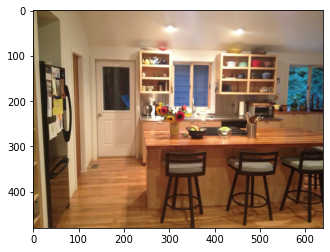

In [11]:
image_name = coco_dataset.get_random_image()
image_path = os.path.join(coco_dataset.images_path, image_name)
img = mpimg.imread(image_path)
plt.imshow(img)
feature = m.predict(image_path)
m.print_categories(feature)